In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.stats import ks_2samp

In [ ]:
# Define Encoder, Decoder, VAE, and Loss function

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        x_hat = torch.sigmoid(self.fc2(h))
        return x_hat

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

#def loss_function(x, x_hat, mu, logvar):
 #   BCE = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
  #  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
   # return BCE + KLD
def loss_function(x, x_hat, mu, logvar):
    MSE = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return 10e-15*MSE + 10000*KLD

Epoch 1, Loss: 37.68995874648094
Epoch 2, Loss: 0.21416175332069398
Epoch 3, Loss: 0.12469953269958496
Epoch 4, Loss: 0.09086811504364013
Epoch 5, Loss: 0.07187774772644043
Epoch 6, Loss: 0.0579567551612854
Epoch 7, Loss: 0.04945570230484009
Epoch 8, Loss: 0.04083430767059326
Epoch 9, Loss: 0.03587368130683899
Epoch 10, Loss: 0.03126534819602966
Epoch 11, Loss: 0.02731633186340332
Epoch 12, Loss: 0.02073046565055847
Epoch 13, Loss: 0.017964422702789307
Epoch 14, Loss: 0.015641838312149048
Epoch 15, Loss: 0.012965947389602661
Epoch 16, Loss: 0.012291043996810913
Epoch 17, Loss: 0.011640340089797974
Epoch 18, Loss: 0.010738134384155273
Epoch 19, Loss: 0.009761661291122437
Epoch 20, Loss: 0.010225176811218262
Epoch 21, Loss: 0.02074000244140625
Epoch 22, Loss: 0.010320156812667847
Epoch 23, Loss: 0.011970847845077515
Epoch 24, Loss: 0.010493218898773193
Epoch 25, Loss: 0.015503644943237305
Epoch 26, Loss: 0.016502410221099852
Epoch 27, Loss: 0.006781458854675293
Epoch 28, Loss: 0.01080933

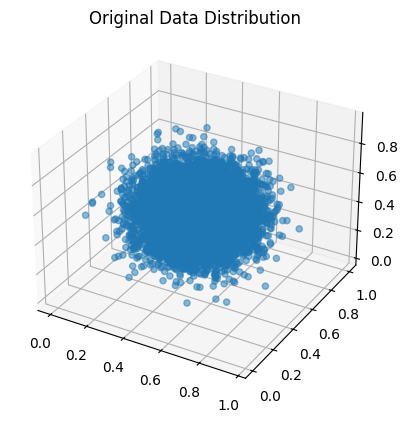

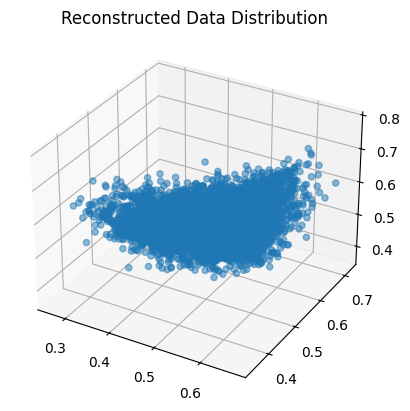

Wasserstein Distance between Original and Reconstructed Data: 0.08987102778002572


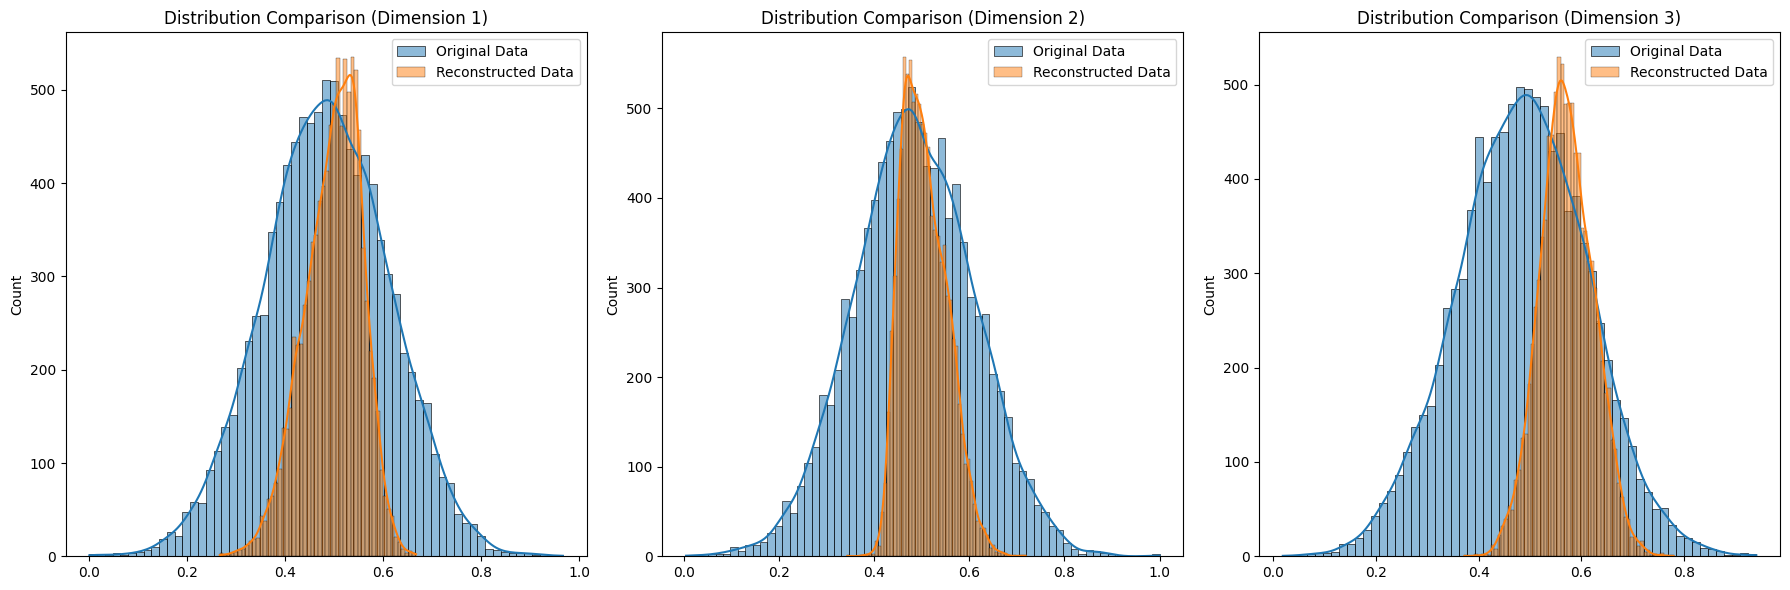

In [ ]:
# Generate normal data points in 3D space (normal distribution with mean 0 and std 1)
num_points = 10000
original_data = np.random.randn(num_points, 3)  # Normal distribution

# Normalize the data to be between 0 and 1
original_data = (original_data - np.min(original_data)) / (np.max(original_data) - np.min(original_data))

# Hyperparameters for VAE
input_dim = 3
hidden_dim = 128
latent_dim = 3
lr = 1e-3
epochs = 100
batch_size = 64

# Convert data to PyTorch tensor
train_tensor = torch.tensor(original_data, dtype=torch.float32)

# Create a DataLoader
train_loader = torch.utils.data.DataLoader(train_tensor, batch_size=batch_size, shuffle=True)

# Initialize VAE
vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=lr)

# Training the VAE
vae.train()
for epoch in range(epochs):
    train_loss = 0
    for x in train_loader:
        x = x.view(-1, input_dim)
        optimizer.zero_grad()
        x_hat, mu, logvar = vae(x)
        loss = loss_function(x, x_hat, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}")

# Visual Comparison: Original Data vs Reconstructed Data

# Reconstruct the data using the VAE
with torch.no_grad():
    x_hat, _, _ = vae(train_tensor)
    reconstructed_data = x_hat.numpy()

# 1. Visualize the Original Data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(original_data[:, 0], original_data[:, 1], original_data[:, 2], alpha=0.5)
ax.set_title("Original Data Distribution")
plt.show()

# 2. Visualize the Reconstructed Data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], reconstructed_data[:, 2], alpha=0.5)
ax.set_title("Reconstructed Data Distribution")
plt.show()

# 3. Wasserstein Distance
def wasserstein_distance(original_data, reconstructed_data):
    distances = cdist(original_data, reconstructed_data)
    return np.mean(np.min(distances, axis=1))

wasserstein_dist = wasserstein_distance(original_data, reconstructed_data)
print(f"Wasserstein Distance between Original and Reconstructed Data: {wasserstein_dist}")

# 4. Histogram Comparison: Original vs Reconstructed
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i in range(3):
    sns.histplot(original_data[:, i], kde=True, label="Original Data", ax=axes[i])
    sns.histplot(reconstructed_data[:, i], kde=True, label="Reconstructed Data", ax=axes[i])
    axes[i].set_title(f"Distribution Comparison (Dimension {i + 1})")
    axes[i].legend()

plt.tight_layout()
plt.show()